## Nota

Para esta primera ejecucion, y la que estara en git, estaba usando la compu, de modo que los tiempos no son los mas optimos

In [1]:
import os
import re

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import cv2
import PIL.Image as Image

from skimage import io, color, transform
from skimage.feature import hog

import time

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, classification_report

C:\Users\FRANZ\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


## Carga de la base (ya guardada)

In [2]:
gray_matrix = np.load('gray_matrix.npy', allow_pickle=True)
hog = np.load('hog.npy', allow_pickle=True)
estados = np.load('estados.npy', allow_pickle=True)
label = np.load('label.npy', allow_pickle=True)

In [3]:
df = pd.DataFrame({'gray_matrix': gray_matrix,'hog': hog,'estados': estados,'label': label})

### Separacion en el df por usar, y el entrenamiento y testeo

In [4]:
dfxusar = df[df['estados'] == 1]
elresto = df[df['estados'] == 0]
dfxusar

,gray_matrix,hog,estados,label
16,"[[175, 166, 185, 198, 202, 213, 212, 209, 210,...","[0.20444939, 0.034390625, 0.026585897, 0.01487...",1,angry
23,"[[26, 29, 30, 35, 45, 60, 108, 145, 161, 161, ...","[0.46974203, 0.15378156, 0.0056655, 0.0, 0.002...",1,angry
30,"[[17, 18, 19, 19, 17, 15, 16, 17, 18, 20, 18, ...","[0.16117984, 0.10060929, 0.12280247, 0.0026138...",1,angry
31,"[[0, 0, 0, 0, 0, 0, 0, 0, 2, 3, 0, 1, 13, 37, ...","[0.17848918, 0.014774916, 0.0, 0.0, 0.0, 0.0, ...",1,angry
45,"[[254, 254, 254, 254, 254, 254, 254, 254, 254,...","[0.025827257, 0.01296422, 0.020755643, 0.0, 0....",1,angry
...,...,...,...,...
35863,"[[9, 38, 69, 99, 86, 102, 111, 105, 65, 58, 64...","[0.23134665, 0.3235038, 0.13396424, 0.05265233...",1,surprise
35869,"[[253, 253, 254, 253, 170, 101, 105, 102, 85, ...","[0.4190711, 0.32569548, 0.0045682807, 0.002312...",1,surprise
35875,"[[252, 247, 146, 93, 94, 89, 99, 94, 93, 83, 9...","[0.32172725, 0.29283354, 0.09000543, 0.0720573...",1,surprise
35878,"[[33, 44, 49, 40, 35, 28, 23, 14, 9, 16, 17, 5...","[0.20763314, 0.31089163, 0.1581842, 0.02511550...",1,surprise


In [5]:
X = np.array(dfxusar['hog'].values.tolist())
y = dfxusar['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=19011)

# K-folds y la comparacion inicial

In [25]:
# Definimos el pool de algoritmos de ensamble a evaluar
algos = []
algos.append(('RandomForest', RandomForestClassifier()))
algos.append(('Neural Network',MLPClassifier()))
algos.append(('KNN',KNeighborsClassifier()))

Mas heavy que el resto

In [26]:
%%time
# Evaluamos cada algoritmo en estrategia de 10-fold-CV
results = []
names = []

# genera el particionamiento de 10 folds que seran usados en cada evaluacion
kfold = KFold(n_splits=10, random_state=42, shuffle= True)  # especifica el particionador de datos a 10-folds CV

for algoname, algo in algos:
    cv_results = cross_val_score(algo, X_train, y_train, cv=kfold, scoring='accuracy')
    results.append(cv_results)
    names.append(algoname)
    print("{}: {} ({})".format(algoname, cv_results.mean(), cv_results.std()))

RandomForest: 0.8004344880405325 (0.022969437523252423)
Neural Network: 0.8359549899846824 (0.018344848443026095)
KNN: 0.8299870390008248 (0.01985212932596414)
CPU times: total: 20min 16s
Wall time: 8min 49s


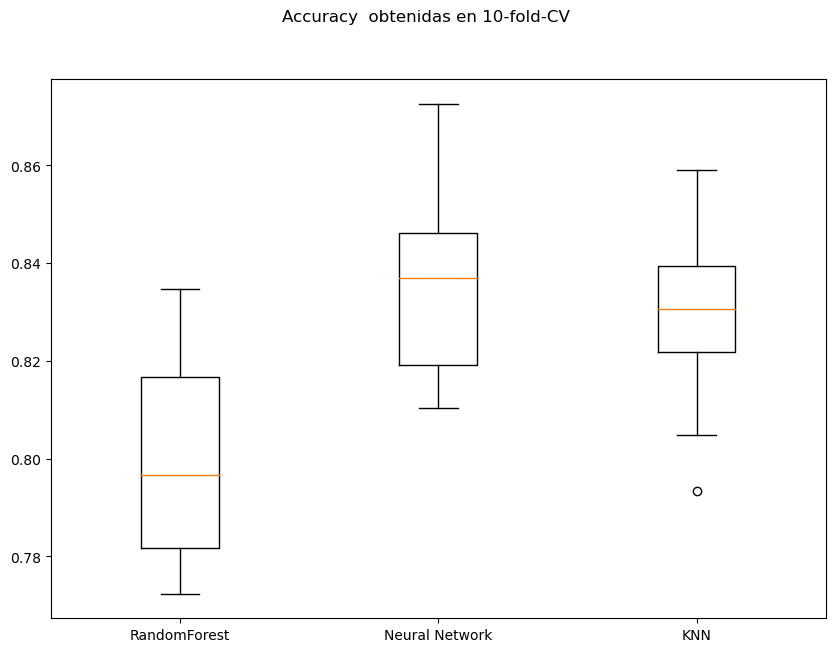

In [27]:
fig = plt.figure(figsize=[10,7])
fig.suptitle('Accuracy  obtenidas en 10-fold-CV')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

# RandomForest

In [28]:
%%time
# Crear el modelo
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# Entrenar el modelo
rf_classifier.fit(X_train, y_train)

CPU times: total: 33.7 s
Wall time: 37.9 s


RandomForestClassifier(random_state=42)

In [29]:
y_pred_e= rf_classifier.predict(X_train)
accuracy = accuracy_score(y_train, y_pred_e)
print(f'Precisión del modelo: {accuracy}')

print(classification_report(y_train, y_pred_e))

Precisión del modelo: 1.0
              precision    recall  f1-score   support

       angry       1.00      1.00      1.00       462
     disgust       1.00      1.00      1.00       435
        fear       1.00      1.00      1.00       579
       happy       1.00      1.00      1.00       650
     neutral       1.00      1.00      1.00       622
         sad       1.00      1.00      1.00       467
    surprise       1.00      1.00      1.00       473

    accuracy                           1.00      3688
   macro avg       1.00      1.00      1.00      3688
weighted avg       1.00      1.00      1.00      3688



In [30]:
# Realizar predicciones en el conjunto de prueba
y_pred = rf_classifier.predict(X_test)

# Evaluar el modelo
accuracy = accuracy_score(y_test, y_pred)
print(f'Precisión del modelo: {accuracy}')

print(classification_report(y_test, y_pred))

Precisión del modelo: 0.8039003250270856
              precision    recall  f1-score   support

       angry       0.84      0.68      0.75       101
     disgust       0.81      0.57      0.67       112
        fear       0.75      0.71      0.73       156
       happy       0.83      0.99      0.90       149
     neutral       0.79      0.89      0.84       153
         sad       0.73      0.80      0.76       119
    surprise       0.90      0.90      0.90       133

    accuracy                           0.80       923
   macro avg       0.81      0.79      0.79       923
weighted avg       0.80      0.80      0.80       923



## Primer GridSearch RF

In [37]:
%%time
from sklearn.model_selection import GridSearchCV

# Define el modelo de Random Forest
rf_classifier = RandomForestClassifier()

# Define una cuadrícula de hiperparámetros que deseas explorar
param_grid = {
    'n_estimators': [150,200,250,300],        # Número de árboles en el bosque
    'max_depth': [10,20,30],      # Profundidad máxima de los árboles
    'min_samples_split': [10,20,30],     # Mínimo de muestras requeridas para dividir un nodo
    'min_samples_leaf': [10,20,30]       # Mínimo de muestras requeridas en una hoja
}

# Realiza la búsqueda en cuadrícula con validación cruzada
grid_search = GridSearchCV(estimator=rf_classifier, param_grid=param_grid, cv=5, scoring='accuracy', verbose=10,n_jobs=8)
grid_search.fit(X_train, y_train)

# Muestra los mejores hiperparámetros encontrados
best_params = grid_search.best_params_
print(f"Mejores hiperparámetros: {best_params}")

# Entrena el modelo con los mejores hiperparámetros en todo el conjunto de entrenamiento
best_rf_classifier = grid_search.best_estimator_
best_rf_classifier.fit(X_train, y_train)

# Evalúa el modelo en el conjunto de prueba
y_pred = best_rf_classifier.predict(X_test)

# Evaluar el modelo
accuracy = accuracy_score(y_test, y_pred)
print(f'Precisión del modelo: {accuracy}')

print(classification_report(y_test, y_pred))

Fitting 5 folds for each of 108 candidates, totalling 540 fits
Mejores hiperparámetros: {'max_depth': 30, 'min_samples_leaf': 10, 'min_samples_split': 20, 'n_estimators': 300}
Precisión del modelo: 0.7963163596966414
              precision    recall  f1-score   support

       angry       0.89      0.69      0.78       101
     disgust       0.83      0.45      0.58       112
        fear       0.77      0.71      0.74       156
       happy       0.79      1.00      0.88       149
     neutral       0.75      0.89      0.81       153
         sad       0.72      0.79      0.76       119
    surprise       0.89      0.95      0.92       133

    accuracy                           0.80       923
   macro avg       0.81      0.78      0.78       923
weighted avg       0.80      0.80      0.79       923

CPU times: total: 2min 29s
Wall time: 54min 49s


## Segundo Grid Search RF

In [ ]:
#'max_depth': 30, 'min_samples_leaf': 10, 'min_samples_split': 20, 'n_estimators': 300
%%time
from sklearn.model_selection import GridSearchCV

# Define el modelo de Random Forest
rf_classifier = RandomForestClassifier(n_estimators=300)

# Define una cuadrícula de hiperparámetros que deseas explorar
param_grid = {
    'max_depth': [27,28,29,30,31,32,33],      # Profundidad máxima de los árboles
    'min_samples_split': [17,18,19,20,21,22,23],     # Mínimo de muestras requeridas para dividir un nodo
    'min_samples_leaf': [7,8,9,10,11,12,13]       # Mínimo de muestras requeridas en una hoja
}

# Realiza la búsqueda en cuadrícula con validación cruzada
grid_search = GridSearchCV(estimator=rf_classifier, param_grid=param_grid, cv=5, scoring='accuracy', verbose=10,n_jobs=8)
grid_search.fit(X_train, y_train)

# Muestra los mejores hiperparámetros encontrados
best_params = grid_search.best_params_
print(f"Mejores hiperparámetros: {best_params}")

# Entrena el modelo con los mejores hiperparámetros en todo el conjunto de entrenamiento
best_rf_classifier = grid_search.best_estimator_
best_rf_classifier.fit(X_train, y_train)

# Evalúa el modelo en el conjunto de prueba
y_pred = best_rf_classifier.predict(X_test)

# Evaluar el modelo
accuracy = accuracy_score(y_test, y_pred)
print(f'Precisión del modelo: {accuracy}')

print(classification_report(y_test, y_pred))

# Redes Neuronales

In [16]:
mlp = MLPClassifier(hidden_layer_sizes=(100,),
                    activation='logistic',
                    solver='sgd',
                    alpha=0,
                    learning_rate='constant',
                    max_iter=10000,
                    tol=1e-6,
                    verbose=True,
                    momentum=0,
                    n_iter_no_change=25,
                    random_state=42)
mlp.fit(X_train, y_train)

Iteration 1, loss = 2.01599649
Iteration 2, loss = 2.00530468
Iteration 3, loss = 1.99603908
Iteration 4, loss = 1.98773040
Iteration 5, loss = 1.98062120
Iteration 6, loss = 1.97453028
Iteration 7, loss = 1.96905867
Iteration 8, loss = 1.96430190
Iteration 9, loss = 1.96014336
Iteration 10, loss = 1.95645144
Iteration 11, loss = 1.95325974
Iteration 12, loss = 1.95050091
Iteration 13, loss = 1.94800850
Iteration 14, loss = 1.94583780
Iteration 15, loss = 1.94387166
Iteration 16, loss = 1.94216024
Iteration 17, loss = 1.94066536
Iteration 18, loss = 1.93930525
Iteration 19, loss = 1.93807622
Iteration 20, loss = 1.93703642
Iteration 21, loss = 1.93607418
Iteration 22, loss = 1.93518657
Iteration 23, loss = 1.93443288
Iteration 24, loss = 1.93379506
Iteration 25, loss = 1.93310326
Iteration 26, loss = 1.93254712
Iteration 27, loss = 1.93206013
Iteration 28, loss = 1.93156347
Iteration 29, loss = 1.93111828
Iteration 30, loss = 1.93071031
Iteration 31, loss = 1.93032783
Iteration 32, los

Iteration 253, loss = 1.88279961
Iteration 254, loss = 1.88257859
Iteration 255, loss = 1.88236466
Iteration 256, loss = 1.88214549
Iteration 257, loss = 1.88191398
Iteration 258, loss = 1.88170098
Iteration 259, loss = 1.88148187
Iteration 260, loss = 1.88124090
Iteration 261, loss = 1.88103222
Iteration 262, loss = 1.88080310
Iteration 263, loss = 1.88058031
Iteration 264, loss = 1.88035530
Iteration 265, loss = 1.88013584
Iteration 266, loss = 1.87991849
Iteration 267, loss = 1.87969279
Iteration 268, loss = 1.87947296
Iteration 269, loss = 1.87923352
Iteration 270, loss = 1.87901314
Iteration 271, loss = 1.87878754
Iteration 272, loss = 1.87857664
Iteration 273, loss = 1.87835693
Iteration 274, loss = 1.87811592
Iteration 275, loss = 1.87789866
Iteration 276, loss = 1.87767759
Iteration 277, loss = 1.87744320
Iteration 278, loss = 1.87722852
Iteration 279, loss = 1.87699087
Iteration 280, loss = 1.87677712
Iteration 281, loss = 1.87654735
Iteration 282, loss = 1.87631315
Iteration 

Iteration 502, loss = 1.82014882
Iteration 503, loss = 1.81986944
Iteration 504, loss = 1.81957336
Iteration 505, loss = 1.81929346
Iteration 506, loss = 1.81899195
Iteration 507, loss = 1.81872520
Iteration 508, loss = 1.81840691
Iteration 509, loss = 1.81812674
Iteration 510, loss = 1.81784619
Iteration 511, loss = 1.81753976
Iteration 512, loss = 1.81725008
Iteration 513, loss = 1.81696859
Iteration 514, loss = 1.81666816
Iteration 515, loss = 1.81638504
Iteration 516, loss = 1.81609335
Iteration 517, loss = 1.81579827
Iteration 518, loss = 1.81548676
Iteration 519, loss = 1.81518858
Iteration 520, loss = 1.81489979
Iteration 521, loss = 1.81461099
Iteration 522, loss = 1.81430214
Iteration 523, loss = 1.81401439
Iteration 524, loss = 1.81372073
Iteration 525, loss = 1.81343209
Iteration 526, loss = 1.81312571
Iteration 527, loss = 1.81282297
Iteration 528, loss = 1.81253981
Iteration 529, loss = 1.81224376
Iteration 530, loss = 1.81194685
Iteration 531, loss = 1.81164702
Iteration 

Iteration 751, loss = 1.73657878
Iteration 752, loss = 1.73619547
Iteration 753, loss = 1.73581519
Iteration 754, loss = 1.73541808
Iteration 755, loss = 1.73503471
Iteration 756, loss = 1.73464519
Iteration 757, loss = 1.73425197
Iteration 758, loss = 1.73389312
Iteration 759, loss = 1.73350231
Iteration 760, loss = 1.73311277
Iteration 761, loss = 1.73271631
Iteration 762, loss = 1.73232499
Iteration 763, loss = 1.73195917
Iteration 764, loss = 1.73155859
Iteration 765, loss = 1.73116418
Iteration 766, loss = 1.73078145
Iteration 767, loss = 1.73037749
Iteration 768, loss = 1.72999726
Iteration 769, loss = 1.72960804
Iteration 770, loss = 1.72920944
Iteration 771, loss = 1.72882200
Iteration 772, loss = 1.72844317
Iteration 773, loss = 1.72803755
Iteration 774, loss = 1.72764775
Iteration 775, loss = 1.72726209
Iteration 776, loss = 1.72686626
Iteration 777, loss = 1.72647308
Iteration 778, loss = 1.72608162
Iteration 779, loss = 1.72566409
Iteration 780, loss = 1.72529010
Iteration 

Iteration 1000, loss = 1.63033876
Iteration 1001, loss = 1.62988325
Iteration 1002, loss = 1.62940178
Iteration 1003, loss = 1.62893629
Iteration 1004, loss = 1.62847483
Iteration 1005, loss = 1.62801169
Iteration 1006, loss = 1.62754708
Iteration 1007, loss = 1.62708119
Iteration 1008, loss = 1.62661487
Iteration 1009, loss = 1.62616110
Iteration 1010, loss = 1.62568809
Iteration 1011, loss = 1.62522726
Iteration 1012, loss = 1.62477240
Iteration 1013, loss = 1.62428779
Iteration 1014, loss = 1.62383681
Iteration 1015, loss = 1.62336575
Iteration 1016, loss = 1.62290534
Iteration 1017, loss = 1.62242236
Iteration 1018, loss = 1.62195645
Iteration 1019, loss = 1.62149328
Iteration 1020, loss = 1.62104108
Iteration 1021, loss = 1.62055995
Iteration 1022, loss = 1.62008709
Iteration 1023, loss = 1.61962692
Iteration 1024, loss = 1.61916015
Iteration 1025, loss = 1.61868867
Iteration 1026, loss = 1.61821173
Iteration 1027, loss = 1.61774397
Iteration 1028, loss = 1.61728509
Iteration 1029

Iteration 1242, loss = 1.51390902
Iteration 1243, loss = 1.51341421
Iteration 1244, loss = 1.51292911
Iteration 1245, loss = 1.51243961
Iteration 1246, loss = 1.51194150
Iteration 1247, loss = 1.51145876
Iteration 1248, loss = 1.51098187
Iteration 1249, loss = 1.51047876
Iteration 1250, loss = 1.50998604
Iteration 1251, loss = 1.50949469
Iteration 1252, loss = 1.50901626
Iteration 1253, loss = 1.50852643
Iteration 1254, loss = 1.50803842
Iteration 1255, loss = 1.50755393
Iteration 1256, loss = 1.50706569
Iteration 1257, loss = 1.50657540
Iteration 1258, loss = 1.50608320
Iteration 1259, loss = 1.50559788
Iteration 1260, loss = 1.50509678
Iteration 1261, loss = 1.50461499
Iteration 1262, loss = 1.50413034
Iteration 1263, loss = 1.50363311
Iteration 1264, loss = 1.50314578
Iteration 1265, loss = 1.50266409
Iteration 1266, loss = 1.50217314
Iteration 1267, loss = 1.50169360
Iteration 1268, loss = 1.50121099
Iteration 1269, loss = 1.50071313
Iteration 1270, loss = 1.50021896
Iteration 1271

Iteration 1484, loss = 1.39797511
Iteration 1485, loss = 1.39749857
Iteration 1486, loss = 1.39705019
Iteration 1487, loss = 1.39658688
Iteration 1488, loss = 1.39613172
Iteration 1489, loss = 1.39567478
Iteration 1490, loss = 1.39520605
Iteration 1491, loss = 1.39474048
Iteration 1492, loss = 1.39428985
Iteration 1493, loss = 1.39383301
Iteration 1494, loss = 1.39336801
Iteration 1495, loss = 1.39290323
Iteration 1496, loss = 1.39245270
Iteration 1497, loss = 1.39200112
Iteration 1498, loss = 1.39153442
Iteration 1499, loss = 1.39106444
Iteration 1500, loss = 1.39060520
Iteration 1501, loss = 1.39016071
Iteration 1502, loss = 1.38969511
Iteration 1503, loss = 1.38925034
Iteration 1504, loss = 1.38878361
Iteration 1505, loss = 1.38833141
Iteration 1506, loss = 1.38786507
Iteration 1507, loss = 1.38741263
Iteration 1508, loss = 1.38693890
Iteration 1509, loss = 1.38649628
Iteration 1510, loss = 1.38604243
Iteration 1511, loss = 1.38558807
Iteration 1512, loss = 1.38512905
Iteration 1513

Iteration 1725, loss = 1.29334858
Iteration 1726, loss = 1.29295860
Iteration 1727, loss = 1.29254735
Iteration 1728, loss = 1.29214622
Iteration 1729, loss = 1.29174763
Iteration 1730, loss = 1.29133256
Iteration 1731, loss = 1.29092644
Iteration 1732, loss = 1.29052167
Iteration 1733, loss = 1.29014714
Iteration 1734, loss = 1.28973181
Iteration 1735, loss = 1.28931751
Iteration 1736, loss = 1.28892026
Iteration 1737, loss = 1.28852432
Iteration 1738, loss = 1.28812953
Iteration 1739, loss = 1.28773075
Iteration 1740, loss = 1.28732831
Iteration 1741, loss = 1.28692036
Iteration 1742, loss = 1.28652743
Iteration 1743, loss = 1.28612802
Iteration 1744, loss = 1.28571887
Iteration 1745, loss = 1.28534062
Iteration 1746, loss = 1.28493311
Iteration 1747, loss = 1.28453461
Iteration 1748, loss = 1.28413472
Iteration 1749, loss = 1.28373772
Iteration 1750, loss = 1.28333651
Iteration 1751, loss = 1.28295445
Iteration 1752, loss = 1.28254197
Iteration 1753, loss = 1.28215380
Iteration 1754

Iteration 1966, loss = 1.20359120
Iteration 1967, loss = 1.20325559
Iteration 1968, loss = 1.20290320
Iteration 1969, loss = 1.20257301
Iteration 1970, loss = 1.20224487
Iteration 1971, loss = 1.20188772
Iteration 1972, loss = 1.20156459
Iteration 1973, loss = 1.20122359
Iteration 1974, loss = 1.20086465
Iteration 1975, loss = 1.20052694
Iteration 1976, loss = 1.20019616
Iteration 1977, loss = 1.19986152
Iteration 1978, loss = 1.19951935
Iteration 1979, loss = 1.19918124
Iteration 1980, loss = 1.19883679
Iteration 1981, loss = 1.19849854
Iteration 1982, loss = 1.19816324
Iteration 1983, loss = 1.19782687
Iteration 1984, loss = 1.19748066
Iteration 1985, loss = 1.19715304
Iteration 1986, loss = 1.19681176
Iteration 1987, loss = 1.19648188
Iteration 1988, loss = 1.19614707
Iteration 1989, loss = 1.19582415
Iteration 1990, loss = 1.19547549
Iteration 1991, loss = 1.19514455
Iteration 1992, loss = 1.19479775
Iteration 1993, loss = 1.19446501
Iteration 1994, loss = 1.19414020
Iteration 1995

Iteration 2207, loss = 1.12802611
Iteration 2208, loss = 1.12773320
Iteration 2209, loss = 1.12745698
Iteration 2210, loss = 1.12716341
Iteration 2211, loss = 1.12687484
Iteration 2212, loss = 1.12660698
Iteration 2213, loss = 1.12631483
Iteration 2214, loss = 1.12602495
Iteration 2215, loss = 1.12576083
Iteration 2216, loss = 1.12545212
Iteration 2217, loss = 1.12516648
Iteration 2218, loss = 1.12486937
Iteration 2219, loss = 1.12459577
Iteration 2220, loss = 1.12431147
Iteration 2221, loss = 1.12402785
Iteration 2222, loss = 1.12376195
Iteration 2223, loss = 1.12346266
Iteration 2224, loss = 1.12317796
Iteration 2225, loss = 1.12287823
Iteration 2226, loss = 1.12260022
Iteration 2227, loss = 1.12232686
Iteration 2228, loss = 1.12203571
Iteration 2229, loss = 1.12175313
Iteration 2230, loss = 1.12147539
Iteration 2231, loss = 1.12118538
Iteration 2232, loss = 1.12090207
Iteration 2233, loss = 1.12062394
Iteration 2234, loss = 1.12034267
Iteration 2235, loss = 1.12005982
Iteration 2236

Iteration 2448, loss = 1.06409578
Iteration 2449, loss = 1.06384146
Iteration 2450, loss = 1.06360987
Iteration 2451, loss = 1.06336405
Iteration 2452, loss = 1.06313453
Iteration 2453, loss = 1.06286545
Iteration 2454, loss = 1.06263189
Iteration 2455, loss = 1.06238188
Iteration 2456, loss = 1.06213212
Iteration 2457, loss = 1.06189071
Iteration 2458, loss = 1.06165519
Iteration 2459, loss = 1.06141445
Iteration 2460, loss = 1.06116733
Iteration 2461, loss = 1.06091906
Iteration 2462, loss = 1.06067576
Iteration 2463, loss = 1.06045182
Iteration 2464, loss = 1.06018811
Iteration 2465, loss = 1.05994700
Iteration 2466, loss = 1.05971285
Iteration 2467, loss = 1.05946293
Iteration 2468, loss = 1.05922411
Iteration 2469, loss = 1.05897924
Iteration 2470, loss = 1.05875283
Iteration 2471, loss = 1.05850026
Iteration 2472, loss = 1.05825778
Iteration 2473, loss = 1.05802063
Iteration 2474, loss = 1.05777760
Iteration 2475, loss = 1.05752669
Iteration 2476, loss = 1.05729913
Iteration 2477

Iteration 2689, loss = 1.00919994
Iteration 2690, loss = 1.00898507
Iteration 2691, loss = 1.00877307
Iteration 2692, loss = 1.00857672
Iteration 2693, loss = 1.00834655
Iteration 2694, loss = 1.00815652
Iteration 2695, loss = 1.00792639
Iteration 2696, loss = 1.00771349
Iteration 2697, loss = 1.00752222
Iteration 2698, loss = 1.00729965
Iteration 2699, loss = 1.00708323
Iteration 2700, loss = 1.00687966
Iteration 2701, loss = 1.00666052
Iteration 2702, loss = 1.00645235
Iteration 2703, loss = 1.00625414
Iteration 2704, loss = 1.00603462
Iteration 2705, loss = 1.00581713
Iteration 2706, loss = 1.00561175
Iteration 2707, loss = 1.00539433
Iteration 2708, loss = 1.00518491
Iteration 2709, loss = 1.00499300
Iteration 2710, loss = 1.00476987
Iteration 2711, loss = 1.00458078
Iteration 2712, loss = 1.00435748
Iteration 2713, loss = 1.00415622
Iteration 2714, loss = 1.00394350
Iteration 2715, loss = 1.00372748
Iteration 2716, loss = 1.00351994
Iteration 2717, loss = 1.00331616
Iteration 2718

Iteration 2931, loss = 0.96115664
Iteration 2932, loss = 0.96097085
Iteration 2933, loss = 0.96078763
Iteration 2934, loss = 0.96059751
Iteration 2935, loss = 0.96042335
Iteration 2936, loss = 0.96022706
Iteration 2937, loss = 0.96005361
Iteration 2938, loss = 0.95986144
Iteration 2939, loss = 0.95967265
Iteration 2940, loss = 0.95948833
Iteration 2941, loss = 0.95931095
Iteration 2942, loss = 0.95912387
Iteration 2943, loss = 0.95893314
Iteration 2944, loss = 0.95875722
Iteration 2945, loss = 0.95856389
Iteration 2946, loss = 0.95839036
Iteration 2947, loss = 0.95819810
Iteration 2948, loss = 0.95802659
Iteration 2949, loss = 0.95784258
Iteration 2950, loss = 0.95764684
Iteration 2951, loss = 0.95745872
Iteration 2952, loss = 0.95728621
Iteration 2953, loss = 0.95708852
Iteration 2954, loss = 0.95690898
Iteration 2955, loss = 0.95673115
Iteration 2956, loss = 0.95654312
Iteration 2957, loss = 0.95637538
Iteration 2958, loss = 0.95619465
Iteration 2959, loss = 0.95599473
Iteration 2960

Iteration 3172, loss = 0.91893087
Iteration 3173, loss = 0.91876967
Iteration 3174, loss = 0.91859844
Iteration 3175, loss = 0.91843366
Iteration 3176, loss = 0.91826962
Iteration 3177, loss = 0.91809895
Iteration 3178, loss = 0.91794909
Iteration 3179, loss = 0.91778347
Iteration 3180, loss = 0.91761373
Iteration 3181, loss = 0.91745088
Iteration 3182, loss = 0.91728542
Iteration 3183, loss = 0.91712828
Iteration 3184, loss = 0.91697075
Iteration 3185, loss = 0.91679136
Iteration 3186, loss = 0.91663627
Iteration 3187, loss = 0.91646898
Iteration 3188, loss = 0.91629016
Iteration 3189, loss = 0.91614421
Iteration 3190, loss = 0.91596992
Iteration 3191, loss = 0.91581067
Iteration 3192, loss = 0.91563865
Iteration 3193, loss = 0.91548042
Iteration 3194, loss = 0.91532183
Iteration 3195, loss = 0.91515630
Iteration 3196, loss = 0.91497625
Iteration 3197, loss = 0.91482704
Iteration 3198, loss = 0.91468163
Iteration 3199, loss = 0.91450275
Iteration 3200, loss = 0.91433900
Iteration 3201

Iteration 3413, loss = 0.88126922
Iteration 3414, loss = 0.88112490
Iteration 3415, loss = 0.88097592
Iteration 3416, loss = 0.88082526
Iteration 3417, loss = 0.88067894
Iteration 3418, loss = 0.88054350
Iteration 3419, loss = 0.88039430
Iteration 3420, loss = 0.88024453
Iteration 3421, loss = 0.88008292
Iteration 3422, loss = 0.87994741
Iteration 3423, loss = 0.87980113
Iteration 3424, loss = 0.87965847
Iteration 3425, loss = 0.87950750
Iteration 3426, loss = 0.87936188
Iteration 3427, loss = 0.87920613
Iteration 3428, loss = 0.87907089
Iteration 3429, loss = 0.87892107
Iteration 3430, loss = 0.87877336
Iteration 3431, loss = 0.87862956
Iteration 3432, loss = 0.87848889
Iteration 3433, loss = 0.87832514
Iteration 3434, loss = 0.87819259
Iteration 3435, loss = 0.87804106
Iteration 3436, loss = 0.87789218
Iteration 3437, loss = 0.87774502
Iteration 3438, loss = 0.87759398
Iteration 3439, loss = 0.87745435
Iteration 3440, loss = 0.87729660
Iteration 3441, loss = 0.87716494
Iteration 3442

Iteration 3654, loss = 0.84742834
Iteration 3655, loss = 0.84728123
Iteration 3656, loss = 0.84715020
Iteration 3657, loss = 0.84701740
Iteration 3658, loss = 0.84687651
Iteration 3659, loss = 0.84675527
Iteration 3660, loss = 0.84663227
Iteration 3661, loss = 0.84649465
Iteration 3662, loss = 0.84635598
Iteration 3663, loss = 0.84621920
Iteration 3664, loss = 0.84609244
Iteration 3665, loss = 0.84596329
Iteration 3666, loss = 0.84582620
Iteration 3667, loss = 0.84569135
Iteration 3668, loss = 0.84556370
Iteration 3669, loss = 0.84542593
Iteration 3670, loss = 0.84530516
Iteration 3671, loss = 0.84515616
Iteration 3672, loss = 0.84502699
Iteration 3673, loss = 0.84489508
Iteration 3674, loss = 0.84476938
Iteration 3675, loss = 0.84463045
Iteration 3676, loss = 0.84450657
Iteration 3677, loss = 0.84435957
Iteration 3678, loss = 0.84422367
Iteration 3679, loss = 0.84409732
Iteration 3680, loss = 0.84396870
Iteration 3681, loss = 0.84383913
Iteration 3682, loss = 0.84370712
Iteration 3683

Iteration 3896, loss = 0.81666699
Iteration 3897, loss = 0.81654734
Iteration 3898, loss = 0.81642650
Iteration 3899, loss = 0.81630104
Iteration 3900, loss = 0.81619333
Iteration 3901, loss = 0.81606042
Iteration 3902, loss = 0.81595207
Iteration 3903, loss = 0.81582086
Iteration 3904, loss = 0.81571323
Iteration 3905, loss = 0.81558752
Iteration 3906, loss = 0.81546066
Iteration 3907, loss = 0.81534415
Iteration 3908, loss = 0.81521122
Iteration 3909, loss = 0.81508473
Iteration 3910, loss = 0.81498121
Iteration 3911, loss = 0.81485087
Iteration 3912, loss = 0.81473272
Iteration 3913, loss = 0.81461603
Iteration 3914, loss = 0.81449208
Iteration 3915, loss = 0.81436843
Iteration 3916, loss = 0.81424805
Iteration 3917, loss = 0.81413449
Iteration 3918, loss = 0.81400579
Iteration 3919, loss = 0.81389863
Iteration 3920, loss = 0.81377811
Iteration 3921, loss = 0.81366188
Iteration 3922, loss = 0.81353560
Iteration 3923, loss = 0.81341700
Iteration 3924, loss = 0.81330604
Iteration 3925

Iteration 4137, loss = 0.78876021
Iteration 4138, loss = 0.78864829
Iteration 4139, loss = 0.78854301
Iteration 4140, loss = 0.78845016
Iteration 4141, loss = 0.78831109
Iteration 4142, loss = 0.78820576
Iteration 4143, loss = 0.78809150
Iteration 4144, loss = 0.78799697
Iteration 4145, loss = 0.78787567
Iteration 4146, loss = 0.78775999
Iteration 4147, loss = 0.78766262
Iteration 4148, loss = 0.78754885
Iteration 4149, loss = 0.78742881
Iteration 4150, loss = 0.78735043
Iteration 4151, loss = 0.78721319
Iteration 4152, loss = 0.78711173
Iteration 4153, loss = 0.78700033
Iteration 4154, loss = 0.78687733
Iteration 4155, loss = 0.78676901
Iteration 4156, loss = 0.78664953
Iteration 4157, loss = 0.78656276
Iteration 4158, loss = 0.78643892
Iteration 4159, loss = 0.78633422
Iteration 4160, loss = 0.78621734
Iteration 4161, loss = 0.78611959
Iteration 4162, loss = 0.78602415
Iteration 4163, loss = 0.78590143
Iteration 4164, loss = 0.78578940
Iteration 4165, loss = 0.78566885
Iteration 4166

Iteration 4379, loss = 0.76308326
Iteration 4380, loss = 0.76297134
Iteration 4381, loss = 0.76287394
Iteration 4382, loss = 0.76277727
Iteration 4383, loss = 0.76268201
Iteration 4384, loss = 0.76257707
Iteration 4385, loss = 0.76247054
Iteration 4386, loss = 0.76237780
Iteration 4387, loss = 0.76227475
Iteration 4388, loss = 0.76216795
Iteration 4389, loss = 0.76206471
Iteration 4390, loss = 0.76197086
Iteration 4391, loss = 0.76185950
Iteration 4392, loss = 0.76176405
Iteration 4393, loss = 0.76165695
Iteration 4394, loss = 0.76155934
Iteration 4395, loss = 0.76146361
Iteration 4396, loss = 0.76136444
Iteration 4397, loss = 0.76126943
Iteration 4398, loss = 0.76115259
Iteration 4399, loss = 0.76105189
Iteration 4400, loss = 0.76095297
Iteration 4401, loss = 0.76086021
Iteration 4402, loss = 0.76076523
Iteration 4403, loss = 0.76066164
Iteration 4404, loss = 0.76055154
Iteration 4405, loss = 0.76045020
Iteration 4406, loss = 0.76035160
Iteration 4407, loss = 0.76025688
Iteration 4408

Iteration 4620, loss = 0.73951599
Iteration 4621, loss = 0.73941377
Iteration 4622, loss = 0.73933321
Iteration 4623, loss = 0.73921848
Iteration 4624, loss = 0.73913488
Iteration 4625, loss = 0.73904164
Iteration 4626, loss = 0.73893670
Iteration 4627, loss = 0.73885178
Iteration 4628, loss = 0.73877158
Iteration 4629, loss = 0.73866281
Iteration 4630, loss = 0.73857912
Iteration 4631, loss = 0.73847423
Iteration 4632, loss = 0.73838318
Iteration 4633, loss = 0.73829015
Iteration 4634, loss = 0.73819094
Iteration 4635, loss = 0.73809260
Iteration 4636, loss = 0.73800678
Iteration 4637, loss = 0.73791470
Iteration 4638, loss = 0.73783888
Iteration 4639, loss = 0.73772357
Iteration 4640, loss = 0.73763114
Iteration 4641, loss = 0.73755142
Iteration 4642, loss = 0.73744703
Iteration 4643, loss = 0.73736316
Iteration 4644, loss = 0.73726299
Iteration 4645, loss = 0.73716002
Iteration 4646, loss = 0.73707572
Iteration 4647, loss = 0.73698733
Iteration 4648, loss = 0.73688780
Iteration 4649

Iteration 4861, loss = 0.71764812
Iteration 4862, loss = 0.71755564
Iteration 4863, loss = 0.71745800
Iteration 4864, loss = 0.71737978
Iteration 4865, loss = 0.71730488
Iteration 4866, loss = 0.71721095
Iteration 4867, loss = 0.71711765
Iteration 4868, loss = 0.71702662
Iteration 4869, loss = 0.71694108
Iteration 4870, loss = 0.71684635
Iteration 4871, loss = 0.71676113
Iteration 4872, loss = 0.71667584
Iteration 4873, loss = 0.71659144
Iteration 4874, loss = 0.71651312
Iteration 4875, loss = 0.71641773
Iteration 4876, loss = 0.71634866
Iteration 4877, loss = 0.71625121
Iteration 4878, loss = 0.71615379
Iteration 4879, loss = 0.71606189
Iteration 4880, loss = 0.71598731
Iteration 4881, loss = 0.71589096
Iteration 4882, loss = 0.71580983
Iteration 4883, loss = 0.71572125
Iteration 4884, loss = 0.71562660
Iteration 4885, loss = 0.71555335
Iteration 4886, loss = 0.71545830
Iteration 4887, loss = 0.71539483
Iteration 4888, loss = 0.71530737
Iteration 4889, loss = 0.71520417
Iteration 4890

Iteration 5102, loss = 0.69725534
Iteration 5103, loss = 0.69716803
Iteration 5104, loss = 0.69708451
Iteration 5105, loss = 0.69699342
Iteration 5106, loss = 0.69691009
Iteration 5107, loss = 0.69683798
Iteration 5108, loss = 0.69676060
Iteration 5109, loss = 0.69667840
Iteration 5110, loss = 0.69660136
Iteration 5111, loss = 0.69650116
Iteration 5112, loss = 0.69643592
Iteration 5113, loss = 0.69633485
Iteration 5114, loss = 0.69626896
Iteration 5115, loss = 0.69618670
Iteration 5116, loss = 0.69609733
Iteration 5117, loss = 0.69602629
Iteration 5118, loss = 0.69593394
Iteration 5119, loss = 0.69586173
Iteration 5120, loss = 0.69577911
Iteration 5121, loss = 0.69569659
Iteration 5122, loss = 0.69560651
Iteration 5123, loss = 0.69552821
Iteration 5124, loss = 0.69546001
Iteration 5125, loss = 0.69536922
Iteration 5126, loss = 0.69528709
Iteration 5127, loss = 0.69519622
Iteration 5128, loss = 0.69512759
Iteration 5129, loss = 0.69504234
Iteration 5130, loss = 0.69496142
Iteration 5131

Iteration 5343, loss = 0.67812573
Iteration 5344, loss = 0.67804137
Iteration 5345, loss = 0.67796232
Iteration 5346, loss = 0.67789750
Iteration 5347, loss = 0.67780864
Iteration 5348, loss = 0.67773172
Iteration 5349, loss = 0.67765062
Iteration 5350, loss = 0.67757999
Iteration 5351, loss = 0.67750824
Iteration 5352, loss = 0.67743012
Iteration 5353, loss = 0.67734349
Iteration 5354, loss = 0.67728390
Iteration 5355, loss = 0.67721069
Iteration 5356, loss = 0.67711201
Iteration 5357, loss = 0.67704172
Iteration 5358, loss = 0.67696496
Iteration 5359, loss = 0.67688297
Iteration 5360, loss = 0.67680778
Iteration 5361, loss = 0.67673131
Iteration 5362, loss = 0.67665598
Iteration 5363, loss = 0.67658715
Iteration 5364, loss = 0.67649735
Iteration 5365, loss = 0.67643619
Iteration 5366, loss = 0.67637115
Iteration 5367, loss = 0.67626055
Iteration 5368, loss = 0.67619793
Iteration 5369, loss = 0.67612288
Iteration 5370, loss = 0.67604410
Iteration 5371, loss = 0.67596816
Iteration 5372

Iteration 5584, loss = 0.66011680
Iteration 5585, loss = 0.66003496
Iteration 5586, loss = 0.65995335
Iteration 5587, loss = 0.65988587
Iteration 5588, loss = 0.65981944
Iteration 5589, loss = 0.65974264
Iteration 5590, loss = 0.65967740
Iteration 5591, loss = 0.65958995
Iteration 5592, loss = 0.65952162
Iteration 5593, loss = 0.65945049
Iteration 5594, loss = 0.65938694
Iteration 5595, loss = 0.65930648
Iteration 5596, loss = 0.65922308
Iteration 5597, loss = 0.65915866
Iteration 5598, loss = 0.65909279
Iteration 5599, loss = 0.65900599
Iteration 5600, loss = 0.65893827
Iteration 5601, loss = 0.65887303
Iteration 5602, loss = 0.65879108
Iteration 5603, loss = 0.65872513
Iteration 5604, loss = 0.65866690
Iteration 5605, loss = 0.65856706
Iteration 5606, loss = 0.65850183
Iteration 5607, loss = 0.65842814
Iteration 5608, loss = 0.65836074
Iteration 5609, loss = 0.65829078
Iteration 5610, loss = 0.65821674
Iteration 5611, loss = 0.65813961
Iteration 5612, loss = 0.65806897
Iteration 5613

Iteration 5825, loss = 0.64307093
Iteration 5826, loss = 0.64300026
Iteration 5827, loss = 0.64292006
Iteration 5828, loss = 0.64286213
Iteration 5829, loss = 0.64279612
Iteration 5830, loss = 0.64272362
Iteration 5831, loss = 0.64265224
Iteration 5832, loss = 0.64258823
Iteration 5833, loss = 0.64251941
Iteration 5834, loss = 0.64245919
Iteration 5835, loss = 0.64238096
Iteration 5836, loss = 0.64232884
Iteration 5837, loss = 0.64224969
Iteration 5838, loss = 0.64218480
Iteration 5839, loss = 0.64209965
Iteration 5840, loss = 0.64204163
Iteration 5841, loss = 0.64197259
Iteration 5842, loss = 0.64189323
Iteration 5843, loss = 0.64182944
Iteration 5844, loss = 0.64175726
Iteration 5845, loss = 0.64170069
Iteration 5846, loss = 0.64163467
Iteration 5847, loss = 0.64154878
Iteration 5848, loss = 0.64148064
Iteration 5849, loss = 0.64142276
Iteration 5850, loss = 0.64134693
Iteration 5851, loss = 0.64129647
Iteration 5852, loss = 0.64121754
Iteration 5853, loss = 0.64115363
Iteration 5854

Iteration 6066, loss = 0.62691634
Iteration 6067, loss = 0.62683481
Iteration 6068, loss = 0.62677764
Iteration 6069, loss = 0.62672185
Iteration 6070, loss = 0.62664925
Iteration 6071, loss = 0.62659139
Iteration 6072, loss = 0.62652534
Iteration 6073, loss = 0.62643985
Iteration 6074, loss = 0.62639383
Iteration 6075, loss = 0.62631898
Iteration 6076, loss = 0.62626743
Iteration 6077, loss = 0.62619936
Iteration 6078, loss = 0.62611711
Iteration 6079, loss = 0.62605921
Iteration 6080, loss = 0.62599615
Iteration 6081, loss = 0.62593148
Iteration 6082, loss = 0.62586679
Iteration 6083, loss = 0.62580569
Iteration 6084, loss = 0.62573239
Iteration 6085, loss = 0.62566395
Iteration 6086, loss = 0.62560312
Iteration 6087, loss = 0.62554481
Iteration 6088, loss = 0.62547244
Iteration 6089, loss = 0.62540275
Iteration 6090, loss = 0.62535787
Iteration 6091, loss = 0.62528452
Iteration 6092, loss = 0.62521742
Iteration 6093, loss = 0.62515241
Iteration 6094, loss = 0.62510175
Iteration 6095

Iteration 6307, loss = 0.61154771
Iteration 6308, loss = 0.61148094
Iteration 6309, loss = 0.61142449
Iteration 6310, loss = 0.61136445
Iteration 6311, loss = 0.61129873
Iteration 6312, loss = 0.61122580
Iteration 6313, loss = 0.61118989
Iteration 6314, loss = 0.61111314
Iteration 6315, loss = 0.61105086
Iteration 6316, loss = 0.61098578
Iteration 6317, loss = 0.61092570
Iteration 6318, loss = 0.61085846
Iteration 6319, loss = 0.61079667
Iteration 6320, loss = 0.61073227
Iteration 6321, loss = 0.61068008
Iteration 6322, loss = 0.61060545
Iteration 6323, loss = 0.61055425
Iteration 6324, loss = 0.61049036
Iteration 6325, loss = 0.61041801
Iteration 6326, loss = 0.61035714
Iteration 6327, loss = 0.61029807
Iteration 6328, loss = 0.61024166
Iteration 6329, loss = 0.61018067
Iteration 6330, loss = 0.61012441
Iteration 6331, loss = 0.61004973
Iteration 6332, loss = 0.60998725
Iteration 6333, loss = 0.60992520
Iteration 6334, loss = 0.60986038
Iteration 6335, loss = 0.60980376
Iteration 6336

Iteration 6548, loss = 0.59687844
Iteration 6549, loss = 0.59681816
Iteration 6550, loss = 0.59676383
Iteration 6551, loss = 0.59670168
Iteration 6552, loss = 0.59663806
Iteration 6553, loss = 0.59658107
Iteration 6554, loss = 0.59652336
Iteration 6555, loss = 0.59646077
Iteration 6556, loss = 0.59639785
Iteration 6557, loss = 0.59634215
Iteration 6558, loss = 0.59627505
Iteration 6559, loss = 0.59623156
Iteration 6560, loss = 0.59617636
Iteration 6561, loss = 0.59610037
Iteration 6562, loss = 0.59604393
Iteration 6563, loss = 0.59599129
Iteration 6564, loss = 0.59592802
Iteration 6565, loss = 0.59585961
Iteration 6566, loss = 0.59579892
Iteration 6567, loss = 0.59575045
Iteration 6568, loss = 0.59570040
Iteration 6569, loss = 0.59562640
Iteration 6570, loss = 0.59557543
Iteration 6571, loss = 0.59550262
Iteration 6572, loss = 0.59545938
Iteration 6573, loss = 0.59540771
Iteration 6574, loss = 0.59532639
Iteration 6575, loss = 0.59527112
Iteration 6576, loss = 0.59520937
Iteration 6577

Iteration 6789, loss = 0.58285046
Iteration 6790, loss = 0.58279311
Iteration 6791, loss = 0.58274886
Iteration 6792, loss = 0.58270058
Iteration 6793, loss = 0.58262993
Iteration 6794, loss = 0.58257936
Iteration 6795, loss = 0.58252279
Iteration 6796, loss = 0.58246601
Iteration 6797, loss = 0.58240335
Iteration 6798, loss = 0.58233724
Iteration 6799, loss = 0.58229732
Iteration 6800, loss = 0.58222703
Iteration 6801, loss = 0.58217287
Iteration 6802, loss = 0.58211651
Iteration 6803, loss = 0.58206874
Iteration 6804, loss = 0.58201423
Iteration 6805, loss = 0.58194483
Iteration 6806, loss = 0.58190712
Iteration 6807, loss = 0.58184621
Iteration 6808, loss = 0.58177183
Iteration 6809, loss = 0.58171014
Iteration 6810, loss = 0.58167494
Iteration 6811, loss = 0.58160550
Iteration 6812, loss = 0.58154990
Iteration 6813, loss = 0.58149373
Iteration 6814, loss = 0.58143863
Iteration 6815, loss = 0.58138914
Iteration 6816, loss = 0.58132496
Iteration 6817, loss = 0.58126213
Iteration 6818

Iteration 7030, loss = 0.56943262
Iteration 7031, loss = 0.56937487
Iteration 7032, loss = 0.56932658
Iteration 7033, loss = 0.56926552
Iteration 7034, loss = 0.56921566
Iteration 7035, loss = 0.56915830
Iteration 7036, loss = 0.56910894
Iteration 7037, loss = 0.56904731
Iteration 7038, loss = 0.56900048
Iteration 7039, loss = 0.56893925
Iteration 7040, loss = 0.56887751
Iteration 7041, loss = 0.56882986
Iteration 7042, loss = 0.56878917
Iteration 7043, loss = 0.56871859
Iteration 7044, loss = 0.56867083
Iteration 7045, loss = 0.56861331
Iteration 7046, loss = 0.56856397
Iteration 7047, loss = 0.56850801
Iteration 7048, loss = 0.56846076
Iteration 7049, loss = 0.56839148
Iteration 7050, loss = 0.56835288
Iteration 7051, loss = 0.56828917
Iteration 7052, loss = 0.56823404
Iteration 7053, loss = 0.56817891
Iteration 7054, loss = 0.56812750
Iteration 7055, loss = 0.56807022
Iteration 7056, loss = 0.56801792
Iteration 7057, loss = 0.56796374
Iteration 7058, loss = 0.56790612
Iteration 7059

Iteration 7271, loss = 0.55655862
Iteration 7272, loss = 0.55649356
Iteration 7273, loss = 0.55643913
Iteration 7274, loss = 0.55639530
Iteration 7275, loss = 0.55634710
Iteration 7276, loss = 0.55628528
Iteration 7277, loss = 0.55624236
Iteration 7278, loss = 0.55618610
Iteration 7279, loss = 0.55612660
Iteration 7280, loss = 0.55608046
Iteration 7281, loss = 0.55603536
Iteration 7282, loss = 0.55597276
Iteration 7283, loss = 0.55593899
Iteration 7284, loss = 0.55587960
Iteration 7285, loss = 0.55582100
Iteration 7286, loss = 0.55575787
Iteration 7287, loss = 0.55571629
Iteration 7288, loss = 0.55566623
Iteration 7289, loss = 0.55559898
Iteration 7290, loss = 0.55555274
Iteration 7291, loss = 0.55550059
Iteration 7292, loss = 0.55545233
Iteration 7293, loss = 0.55539169
Iteration 7294, loss = 0.55535774
Iteration 7295, loss = 0.55530506
Iteration 7296, loss = 0.55524791
Iteration 7297, loss = 0.55518274
Iteration 7298, loss = 0.55514986
Iteration 7299, loss = 0.55509298
Iteration 7300

Iteration 7513, loss = 0.54411156
Iteration 7514, loss = 0.54407320
Iteration 7515, loss = 0.54402054
Iteration 7516, loss = 0.54396389
Iteration 7517, loss = 0.54391292
Iteration 7518, loss = 0.54386209
Iteration 7519, loss = 0.54381138
Iteration 7520, loss = 0.54374923
Iteration 7521, loss = 0.54369384
Iteration 7522, loss = 0.54365882
Iteration 7523, loss = 0.54360193
Iteration 7524, loss = 0.54355439
Iteration 7525, loss = 0.54351541
Iteration 7526, loss = 0.54344774
Iteration 7527, loss = 0.54340227
Iteration 7528, loss = 0.54335755
Iteration 7529, loss = 0.54330862
Iteration 7530, loss = 0.54326100
Iteration 7531, loss = 0.54320196
Iteration 7532, loss = 0.54315573
Iteration 7533, loss = 0.54309816
Iteration 7534, loss = 0.54305362
Iteration 7535, loss = 0.54300530
Iteration 7536, loss = 0.54295856
Iteration 7537, loss = 0.54291212
Iteration 7538, loss = 0.54285955
Iteration 7539, loss = 0.54281186
Iteration 7540, loss = 0.54275271
Iteration 7541, loss = 0.54270066
Iteration 7542

Iteration 7754, loss = 0.53219304
Iteration 7755, loss = 0.53214442
Iteration 7756, loss = 0.53209262
Iteration 7757, loss = 0.53205014
Iteration 7758, loss = 0.53200370
Iteration 7759, loss = 0.53195102
Iteration 7760, loss = 0.53189183
Iteration 7761, loss = 0.53185478
Iteration 7762, loss = 0.53180106
Iteration 7763, loss = 0.53175659
Iteration 7764, loss = 0.53170211
Iteration 7765, loss = 0.53164976
Iteration 7766, loss = 0.53161747
Iteration 7767, loss = 0.53156911
Iteration 7768, loss = 0.53151331
Iteration 7769, loss = 0.53147302
Iteration 7770, loss = 0.53140568
Iteration 7771, loss = 0.53136672
Iteration 7772, loss = 0.53132886
Iteration 7773, loss = 0.53127440
Iteration 7774, loss = 0.53123535
Iteration 7775, loss = 0.53118285
Iteration 7776, loss = 0.53112878
Iteration 7777, loss = 0.53106913
Iteration 7778, loss = 0.53102567
Iteration 7779, loss = 0.53097913
Iteration 7780, loss = 0.53093184
Iteration 7781, loss = 0.53089636
Iteration 7782, loss = 0.53083925
Iteration 7783

Iteration 7995, loss = 0.52071696
Iteration 7996, loss = 0.52065022
Iteration 7997, loss = 0.52060993
Iteration 7998, loss = 0.52058303
Iteration 7999, loss = 0.52051519
Iteration 8000, loss = 0.52048568
Iteration 8001, loss = 0.52043555
Iteration 8002, loss = 0.52038081
Iteration 8003, loss = 0.52033695
Iteration 8004, loss = 0.52028998
Iteration 8005, loss = 0.52022845
Iteration 8006, loss = 0.52019409
Iteration 8007, loss = 0.52015114
Iteration 8008, loss = 0.52009362
Iteration 8009, loss = 0.52005904
Iteration 8010, loss = 0.52001562
Iteration 8011, loss = 0.51995823
Iteration 8012, loss = 0.51990838
Iteration 8013, loss = 0.51987952
Iteration 8014, loss = 0.51982164
Iteration 8015, loss = 0.51978646
Iteration 8016, loss = 0.51972998
Iteration 8017, loss = 0.51969606
Iteration 8018, loss = 0.51963285
Iteration 8019, loss = 0.51958562
Iteration 8020, loss = 0.51954687
Iteration 8021, loss = 0.51949784
Iteration 8022, loss = 0.51945428
Iteration 8023, loss = 0.51940892
Iteration 8024

Iteration 8236, loss = 0.50962241
Iteration 8237, loss = 0.50957705
Iteration 8238, loss = 0.50952621
Iteration 8239, loss = 0.50949396
Iteration 8240, loss = 0.50945539
Iteration 8241, loss = 0.50940267
Iteration 8242, loss = 0.50935782
Iteration 8243, loss = 0.50932321
Iteration 8244, loss = 0.50926592
Iteration 8245, loss = 0.50922876
Iteration 8246, loss = 0.50917295
Iteration 8247, loss = 0.50912627
Iteration 8248, loss = 0.50909557
Iteration 8249, loss = 0.50904418
Iteration 8250, loss = 0.50899944
Iteration 8251, loss = 0.50895350
Iteration 8252, loss = 0.50890374
Iteration 8253, loss = 0.50886466
Iteration 8254, loss = 0.50883858
Iteration 8255, loss = 0.50876598
Iteration 8256, loss = 0.50873232
Iteration 8257, loss = 0.50868759
Iteration 8258, loss = 0.50863589
Iteration 8259, loss = 0.50859526
Iteration 8260, loss = 0.50854882
Iteration 8261, loss = 0.50849579
Iteration 8262, loss = 0.50845097
Iteration 8263, loss = 0.50840620
Iteration 8264, loss = 0.50835940
Iteration 8265

Iteration 8477, loss = 0.49892199
Iteration 8478, loss = 0.49888374
Iteration 8479, loss = 0.49884453
Iteration 8480, loss = 0.49880221
Iteration 8481, loss = 0.49875589
Iteration 8482, loss = 0.49870580
Iteration 8483, loss = 0.49866357
Iteration 8484, loss = 0.49862500
Iteration 8485, loss = 0.49859172
Iteration 8486, loss = 0.49853380
Iteration 8487, loss = 0.49849250
Iteration 8488, loss = 0.49844509
Iteration 8489, loss = 0.49839956
Iteration 8490, loss = 0.49836244
Iteration 8491, loss = 0.49832259
Iteration 8492, loss = 0.49828203
Iteration 8493, loss = 0.49822762
Iteration 8494, loss = 0.49818451
Iteration 8495, loss = 0.49813686
Iteration 8496, loss = 0.49809834
Iteration 8497, loss = 0.49805542
Iteration 8498, loss = 0.49800692
Iteration 8499, loss = 0.49796314
Iteration 8500, loss = 0.49792645
Iteration 8501, loss = 0.49787651
Iteration 8502, loss = 0.49785025
Iteration 8503, loss = 0.49779756
Iteration 8504, loss = 0.49774236
Iteration 8505, loss = 0.49770174
Iteration 8506

Iteration 8718, loss = 0.48858770
Iteration 8719, loss = 0.48854333
Iteration 8720, loss = 0.48849537
Iteration 8721, loss = 0.48846262
Iteration 8722, loss = 0.48840635
Iteration 8723, loss = 0.48838054
Iteration 8724, loss = 0.48833445
Iteration 8725, loss = 0.48828064
Iteration 8726, loss = 0.48824166
Iteration 8727, loss = 0.48820888
Iteration 8728, loss = 0.48815751
Iteration 8729, loss = 0.48812129
Iteration 8730, loss = 0.48807545
Iteration 8731, loss = 0.48803698
Iteration 8732, loss = 0.48798581
Iteration 8733, loss = 0.48795966
Iteration 8734, loss = 0.48791847
Iteration 8735, loss = 0.48786538
Iteration 8736, loss = 0.48782493
Iteration 8737, loss = 0.48779431
Iteration 8738, loss = 0.48773716
Iteration 8739, loss = 0.48769156
Iteration 8740, loss = 0.48765314
Iteration 8741, loss = 0.48761602
Iteration 8742, loss = 0.48758202
Iteration 8743, loss = 0.48751976
Iteration 8744, loss = 0.48748585
Iteration 8745, loss = 0.48744389
Iteration 8746, loss = 0.48740116
Iteration 8747

Iteration 8959, loss = 0.47855981
Iteration 8960, loss = 0.47852256
Iteration 8961, loss = 0.47847822
Iteration 8962, loss = 0.47844684
Iteration 8963, loss = 0.47839076
Iteration 8964, loss = 0.47836557
Iteration 8965, loss = 0.47831369
Iteration 8966, loss = 0.47826597
Iteration 8967, loss = 0.47823598
Iteration 8968, loss = 0.47819030
Iteration 8969, loss = 0.47815877
Iteration 8970, loss = 0.47811454
Iteration 8971, loss = 0.47806881
Iteration 8972, loss = 0.47803193
Iteration 8973, loss = 0.47798861
Iteration 8974, loss = 0.47794458
Iteration 8975, loss = 0.47791074
Iteration 8976, loss = 0.47786420
Iteration 8977, loss = 0.47783225
Iteration 8978, loss = 0.47778788
Iteration 8979, loss = 0.47774971
Iteration 8980, loss = 0.47770288
Iteration 8981, loss = 0.47766765
Iteration 8982, loss = 0.47763262
Iteration 8983, loss = 0.47757474
Iteration 8984, loss = 0.47754508
Iteration 8985, loss = 0.47749804
Iteration 8986, loss = 0.47745480
Iteration 8987, loss = 0.47740364
Iteration 8988

Iteration 9200, loss = 0.46886018
Iteration 9201, loss = 0.46879903
Iteration 9202, loss = 0.46877313
Iteration 9203, loss = 0.46873047
Iteration 9204, loss = 0.46868810
Iteration 9205, loss = 0.46864796
Iteration 9206, loss = 0.46861546
Iteration 9207, loss = 0.46857772
Iteration 9208, loss = 0.46853486
Iteration 9209, loss = 0.46850261
Iteration 9210, loss = 0.46845023
Iteration 9211, loss = 0.46841232
Iteration 9212, loss = 0.46838217
Iteration 9213, loss = 0.46835525
Iteration 9214, loss = 0.46829116
Iteration 9215, loss = 0.46825371
Iteration 9216, loss = 0.46820857
Iteration 9217, loss = 0.46818321
Iteration 9218, loss = 0.46813362
Iteration 9219, loss = 0.46809423
Iteration 9220, loss = 0.46806643
Iteration 9221, loss = 0.46801303
Iteration 9222, loss = 0.46798159
Iteration 9223, loss = 0.46793583
Iteration 9224, loss = 0.46789884
Iteration 9225, loss = 0.46786478
Iteration 9226, loss = 0.46783555
Iteration 9227, loss = 0.46778068
Iteration 9228, loss = 0.46775059
Iteration 9229

Iteration 9441, loss = 0.45943561
Iteration 9442, loss = 0.45940566
Iteration 9443, loss = 0.45936398
Iteration 9444, loss = 0.45933030
Iteration 9445, loss = 0.45928876
Iteration 9446, loss = 0.45924761
Iteration 9447, loss = 0.45921346
Iteration 9448, loss = 0.45915898
Iteration 9449, loss = 0.45913031
Iteration 9450, loss = 0.45909243
Iteration 9451, loss = 0.45904485
Iteration 9452, loss = 0.45902855
Iteration 9453, loss = 0.45897711
Iteration 9454, loss = 0.45895745
Iteration 9455, loss = 0.45890603
Iteration 9456, loss = 0.45887578
Iteration 9457, loss = 0.45882010
Iteration 9458, loss = 0.45879122
Iteration 9459, loss = 0.45875008
Iteration 9460, loss = 0.45870917
Iteration 9461, loss = 0.45867524
Iteration 9462, loss = 0.45863351
Iteration 9463, loss = 0.45860018
Iteration 9464, loss = 0.45855110
Iteration 9465, loss = 0.45852228
Iteration 9466, loss = 0.45847850
Iteration 9467, loss = 0.45844719
Iteration 9468, loss = 0.45840577
Iteration 9469, loss = 0.45837106
Iteration 9470

Iteration 9682, loss = 0.45030945
Iteration 9683, loss = 0.45026748
Iteration 9684, loss = 0.45023670
Iteration 9685, loss = 0.45019473
Iteration 9686, loss = 0.45014934
Iteration 9687, loss = 0.45011969
Iteration 9688, loss = 0.45009043
Iteration 9689, loss = 0.45004547
Iteration 9690, loss = 0.45001414
Iteration 9691, loss = 0.44997674
Iteration 9692, loss = 0.44993477
Iteration 9693, loss = 0.44990167
Iteration 9694, loss = 0.44985744
Iteration 9695, loss = 0.44981318
Iteration 9696, loss = 0.44977737
Iteration 9697, loss = 0.44973646
Iteration 9698, loss = 0.44971107
Iteration 9699, loss = 0.44969249
Iteration 9700, loss = 0.44964069
Iteration 9701, loss = 0.44959581
Iteration 9702, loss = 0.44956158
Iteration 9703, loss = 0.44951790
Iteration 9704, loss = 0.44948713
Iteration 9705, loss = 0.44945739
Iteration 9706, loss = 0.44941649
Iteration 9707, loss = 0.44937307
Iteration 9708, loss = 0.44933380
Iteration 9709, loss = 0.44930341
Iteration 9710, loss = 0.44927621
Iteration 9711

Iteration 9923, loss = 0.44142767
Iteration 9924, loss = 0.44138658
Iteration 9925, loss = 0.44136432
Iteration 9926, loss = 0.44131984
Iteration 9927, loss = 0.44128436
Iteration 9928, loss = 0.44124479
Iteration 9929, loss = 0.44121917
Iteration 9930, loss = 0.44117026
Iteration 9931, loss = 0.44114502
Iteration 9932, loss = 0.44111771
Iteration 9933, loss = 0.44106953
Iteration 9934, loss = 0.44102402
Iteration 9935, loss = 0.44100503
Iteration 9936, loss = 0.44095699
Iteration 9937, loss = 0.44092279
Iteration 9938, loss = 0.44089028
Iteration 9939, loss = 0.44084930
Iteration 9940, loss = 0.44081287
Iteration 9941, loss = 0.44078835
Iteration 9942, loss = 0.44074106
Iteration 9943, loss = 0.44071224
Iteration 9944, loss = 0.44066628
Iteration 9945, loss = 0.44063823
Iteration 9946, loss = 0.44059853
Iteration 9947, loss = 0.44055229
Iteration 9948, loss = 0.44051647
Iteration 9949, loss = 0.44049080
Iteration 9950, loss = 0.44044797
Iteration 9951, loss = 0.44042330
Iteration 9952

C:\Users\FRANZ\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10000) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPClassifier(activation='logistic', alpha=0, max_iter=10000, momentum=0,
              n_iter_no_change=25, random_state=42, solver='sgd', tol=1e-06,
              verbose=True)

In [17]:
y_pred_e= mlp.predict(X_train)
accuracy = accuracy_score(y_train, y_pred_e)
print(f'Precisión del modelo: {accuracy}')

print(classification_report(y_train, y_pred_e))

Precisión del modelo: 0.8695770065075922
              precision    recall  f1-score   support

       angry       0.84      0.84      0.84       462
     disgust       0.76      0.67      0.71       435
        fear       0.82      0.78      0.80       579
       happy       0.95      0.99      0.97       650
     neutral       0.93      0.94      0.94       622
         sad       0.80      0.85      0.82       467
    surprise       0.92      0.95      0.94       473

    accuracy                           0.87      3688
   macro avg       0.86      0.86      0.86      3688
weighted avg       0.87      0.87      0.87      3688



In [18]:
# Realizar predicciones en el conjunto de prueba
y_pred = mlp.predict(X_test)

# Evaluar el modelo
accuracy = accuracy_score(y_test, y_pred)
print(f'Precisión del modelo: {accuracy}')

print(classification_report(y_test, y_pred))

Precisión del modelo: 0.7908992416034669
              precision    recall  f1-score   support

       angry       0.67      0.69      0.68       101
     disgust       0.56      0.48      0.52       112
        fear       0.73      0.77      0.75       156
       happy       0.92      0.97      0.94       149
     neutral       0.89      0.88      0.88       153
         sad       0.73      0.74      0.74       119
    surprise       0.92      0.89      0.90       133

    accuracy                           0.79       923
   macro avg       0.77      0.78      0.77       923
weighted avg       0.79      0.79      0.79       923



In [ ]:
%%time

# Define el modelo de Red Neuronal
mlp = MLPClassifier(hidden_layer_sizes=(100,),
                    activation='logistic',
                    solver='sgd',
                    alpha=0,
                    learning_rate='constant',
                    max_iter=10000,
                    tol=1e-4,
                    verbose=True,
                    momentum=0,
                    n_iter_no_change=25,
                    random_state=42)

# Define una cuadrícula de hiperparámetros que deseas explorar
param_grid = {
    'max_iter': [10000,15000,20000,25000],
    'learning_rate_init': [0.1,0.01,0.001,0.0001,0.00001],
    'batch_size': [1,5000,10000,15000,20000]
}

# Realiza la búsqueda en cuadrícula con validación cruzada
grid_search = GridSearchCV(estimator=mpl, param_grid=param_grid, cv=5, scoring='accuracy', verbose=10,n_jobs=8)
grid_search.fit(X_train, y_train)

# Muestra los mejores hiperparámetros encontrados
best_params = grid_search.best_params_
print(f"Mejores hiperparámetros: {best_params}")

# Entrena el modelo con los mejores hiperparámetros en todo el conjunto de entrenamiento
best_rf_classifier = grid_search.best_estimator_
best_rf_classifier.fit(X_train, y_train)

# Evalúa el modelo en el conjunto de prueba
y_pred = best_rf_classifier.predict(X_test)

# Evaluar el modelo
accuracy = accuracy_score(y_test, y_pred)
print(f'Precisión del modelo: {accuracy}')

print(classification_report(y_test, y_pred))

# KNN

In [19]:
knn = KNeighborsClassifier(n_neighbors=5)  # Cambia 5 por el número de vecinos que desees utilizar
knn.fit(X_train, y_train)

KNeighborsClassifier()

In [20]:
y_pred_e= knn.predict(X_train)
accuracy = accuracy_score(y_train, y_pred_e)
print(f'Precisión del modelo: {accuracy}')

print(classification_report(y_train, y_pred_e))

Precisión del modelo: 0.9088937093275488
              precision    recall  f1-score   support

       angry       0.90      0.93      0.91       462
     disgust       0.86      0.76      0.81       435
        fear       0.91      0.90      0.90       579
       happy       0.92      1.00      0.96       650
     neutral       0.88      0.97      0.92       622
         sad       0.97      0.76      0.85       467
    surprise       0.94      0.98      0.96       473

    accuracy                           0.91      3688
   macro avg       0.91      0.90      0.90      3688
weighted avg       0.91      0.91      0.91      3688



In [21]:
# Realizar predicciones en el conjunto de prueba
y_pred = knn.predict(X_test)

# Evaluar el modelo
accuracy = accuracy_score(y_test, y_pred)
print(f'Precisión del modelo: {accuracy}')

print(classification_report(y_test, y_pred))

Precisión del modelo: 0.8114842903575298
              precision    recall  f1-score   support

       angry       0.75      0.75      0.75       101
     disgust       0.73      0.49      0.59       112
        fear       0.80      0.81      0.81       156
       happy       0.80      0.99      0.89       149
     neutral       0.80      0.95      0.87       153
         sad       0.95      0.62      0.75       119
    surprise       0.86      0.93      0.90       133

    accuracy                           0.81       923
   macro avg       0.81      0.79      0.79       923
weighted avg       0.81      0.81      0.80       923



# Optimizacion - GridSearch

In [29]:
%%time
from sklearn.model_selection import GridSearchCV
# Define el modelo de KNN
knn = KNeighborsClassifier()

# Define una cuadrícula de hiperparámetros que deseas explorar
param_grid = {
    'n_neighbors': [1,2,3,4,5,6,7,8,9,10],
    'p':[1,2]
}

# Realiza la búsqueda en cuadrícula con validación cruzada
grid_search = GridSearchCV(estimator=knn, param_grid=param_grid, cv=5, scoring='accuracy', verbose=10,n_jobs=8)
grid_search.fit(X_train, y_train)

# Muestra los mejores hiperparámetros encontrados
best_params = grid_search.best_params_
print(f"Mejores hiperparámetros: {best_params}")

# Entrena el modelo con los mejores hiperparámetros en todo el conjunto de entrenamiento
best_rf_classifier = grid_search.best_estimator_
best_rf_classifier.fit(X_train, y_train)

# Evalúa el modelo en el conjunto de prueba
y_pred = best_rf_classifier.predict(X_test)

# Evaluar el modelo
accuracy = accuracy_score(y_test, y_pred)
print(f'Precisión del modelo: {accuracy}')

print(classification_report(y_test, y_pred))

Fitting 5 folds for each of 20 candidates, totalling 100 fits


C:\Users\FRANZ\anaconda3\Lib\site-packages\sklearn\model_selection\_search.py:976: UserWarning: One or more of the test scores are non-finite: [       nan 0.87202053        nan 0.83948293        nan 0.83839855
        nan 0.82782025        nan 0.81833148        nan 0.80992929
        nan 0.80260376        nan 0.79284251        nan 0.78145268
        nan 0.77684343]
  warnings.warn(


Mejores hiperparámetros: {'n_neighbors': 1, 'p': 2}
Precisión del modelo: 0.8634886240520043
              precision    recall  f1-score   support

       angry       0.87      0.87      0.87       101
     disgust       0.83      0.62      0.71       112
        fear       0.83      0.88      0.85       156
       happy       0.88      1.00      0.93       149
     neutral       0.83      0.97      0.90       153
         sad       0.94      0.66      0.78       119
    surprise       0.90      0.93      0.92       133

    accuracy                           0.86       923
   macro avg       0.87      0.85      0.85       923
weighted avg       0.87      0.86      0.86       923

CPU times: total: 2.88 s
Wall time: 14.4 s
